# Training a neural network on QM9

This tutorial will explain how to use SchNetPack for training a model
on the QM9 dataset and how the trained model can be used for further applications.

First, we import the necessary modules and create a new directory for the data and our model.

In [2]:
%load_ext autoreload
%autoreload 2

In [8]:
import os
from pathlib import Path
import schnetpack as spk
from schnet_atom import PCPS, NormalizeProperty
import schnetpack.transform as trn

import torch
import torchmetrics
import pytorch_lightning as pl
import matplotlib.pyplot as plt
from sklearn.metrics import (
    r2_score, mean_absolute_error, mean_squared_error
)
import matplotlib as mpl
from matplotlib.offsetbox import AnchoredText
import wandb
import numpy as np

In [5]:
def parity_plot(
    y, 
    yhat, 
    ax=None, 
    include_parity: bool= True, 
    include_scores: bool = True, 
    label:str = None,
    alpha: float = 0.5,
):
    """ Make a parity plot"""
    
    if ax is None:
        fig, ax = plt.subplots(1)

    # Metrics
    mae = mean_absolute_error(y,yhat)
    r2= r2_score(y,yhat)
    rmse = mean_squared_error(y,yhat)**(0.5)
        
    # Scatter plot
    ax.scatter(y, yhat, label=label, alpha=alpha)
    
    # Parity line
    if include_parity:
        combined = np.vstack((y,yhat))
        min_y = np.min(combined)
        max_y = np.max(combined)
        ax.plot([min_y, max_y], [min_y, max_y], "k--")
    
    # Formatting
    ax.set_ylabel("Predicted")
    ax.set_xlabel("Measured")
    if include_scores:
        at = AnchoredText(
        f"MAE = {mae:.2f}\nRMSE = {rmse:.2f}\n$R^2$={r2:.2f}", prop=dict(size=10), frameon=True, loc='upper left')
        at.patch.set_boxstyle("round,pad=0.,rounding_size=0.2")
        ax.add_artist(at)
    return ax

## Loading the data

As explained in the [previous tutorial](tutorial_01_preparing_data.ipynb), datasets in SchNetPack are loaded with the `AtomsLoader` class or one of the sub-classes that are specialized for common benchmark datasets. 
The `QM9` dataset class will download and convert the data. We will only use the inner energy at 0K `U0`, so all other properties do not need to be loaded:

In [9]:
tmp_dir = Path('./pcps_rdkit')
if not os.path.exists(tmp_dir):
    os.makedirs(tmp_dir)

pcpsData = PCPS(
    rawpath_xyz=data_path / "xyz_files", 
    rawpath_csv=data_path / "pcp_saft_cleaned.csv", 
    datapath=f'{tmp_dir}/pcps.db', 
    batch_size=100,
    num_train=1000,
    num_val=100,
    transforms=[
        trn.SubtractCenterOfMass(),
        trn.MatScipyNeighborList(cutoff=5.),
        NormalizeProperty("epsilon_k", inverse=False),
        trn.CastTo32()
    ],
    #property_units={PCPS.mu: 'Debye'},
    num_workers=2,
    split_file=os.path.join(tmp_dir, "split.npz"),
    pin_memory=True, # set to false, when not using a GPU
)

pcpsData.prepare_data()
pcpsData.setup()

100%|██████████| 10/10 [00:01<00:00,  8.22it/s]


In [7]:
mean_epsilon_k, _ = pcpsData.get_stats(
    PCPS.epsilon_k, divide_by_atoms=False, remove_atomref=True
)
mean_epsilon_k = mean_epsilon_k.item()
print(f"Mean epsilon/k: {mean_epsilon_k:.02f}")

100%|██████████| 10/10 [00:06<00:00,  1.53it/s]

Mean epsilon/k: -41.60


## Setting up the model

Next, we need to build the model and define how it should be trained.

In SchNetPack, a neural network potential usually consists of three parts:

1. A list of input modules that prepare the batched data before the building the representation.
   This includes, e.g., the calculation of pairwise distances between atoms based on neighbor indices or add auxiliary
   inputs for response properties.
2. The representation which either constructs atom-wise features, e.g. with SchNet or PaiNN.
3. One or more output modules for property prediction.

Here, we use the `SchNet` representation with 3 interaction layers, a 5 Angstrom cosine cutoff with pairwise distances
expanded on 20 Gaussians and 50 atomwise features and convolution filters, since we only have a few
training examples. Then, we use an `Atomwise` module to predict the inner energy $U_0$ by summing over atom-wise
energy contributions.

In [15]:
cutoff = 5.
n_atom_basis = 128

pairwise_distance = spk.atomistic.PairwiseDistances() # calculates pairwise distances between atoms
radial_basis = spk.nn.GaussianRBF(n_rbf=20, cutoff=cutoff)
painn = spk.representation.PaiNN(
    n_atom_basis=n_atom_basis, n_interactions=3,
    radial_basis=radial_basis,
    cutoff_fn=spk.nn.CosineCutoff(cutoff)
)
pred_epsilon_k = spk.atomistic.Atomwise(
    n_in=n_atom_basis, 
    output_key="epsilon_k",
)
pred_mu = spk.atomistic.DipoleMoment(
    n_in=n_atom_basis, 
    dipole_key='mu', 
    predict_magnitude=True, 
    use_vector_representation=False
)

nnpot = spk.model.NeuralNetworkPotential(
    representation=painn,
    input_modules=[pairwise_distance],
    output_modules=[pred_mu, pred_epsilon_k],
    postprocessors=[
        trn.CastTo64(), 
        NormalizeProperty("epsilon_k", inverse=True)
    ]
)

The last argument here is a list of postprocessors that will only be used if `nnpot.inference_mode=True` is set.
It will not be used in training or validation, but only for predictions.
Here, this is used to deal with numerical accuracy and normalization of model outputs:
To make training easier, we have subtracted single atom energies as well as the mean energy per atom
in the preprocessing (see above).
This does not matter for the loss, but for the final prediction we want to get the real energies.
Additionally, we have removed the energy offsets *before* casting to float32 in the preprocessor.
This avoids loss of numerical precision.
Analog to this, we also have to first cast to float64, before re-adding the offsets in the post-processor

The output modules store the prediction in a dictionary under the `output_key` (here: `QM9.U0`), which is connected to
a target property with loss functions and evaluation metrics using the `ModelOutput` class:

In [12]:
1./np.abs(mean_epsilon_k)

0.024040540275890383

In [12]:
output_epsilon_k = spk.task.ModelOutput(
    name=PCPS.epsilon_k,
    loss_fn=torch.nn.MSELoss(),
    loss_weight=1.,
    metrics={
        "MAE": torchmetrics.MeanAbsoluteError(),
        "MSE": torchmetrics.MeanSquaredError()
    }
)
output_mu = spk.task.ModelOutput(
    name=PCPS.mu,
    loss_fn=torch.nn.MSELoss(),
    loss_weight=1.,
    metrics={
        "MAE": torchmetrics.MeanAbsoluteError(),
        "MSE": torchmetrics.MeanSquaredError()
    }
)

In [13]:
task = spk.task.AtomisticTask(
    model=nnpot,
    outputs=[output_mu,output_epsilon_k],
    optimizer_cls=torch.optim.AdamW,
    optimizer_args={"lr": 1e-3},
    scheduler_cls=torch.optim.lr_scheduler.ReduceLROnPlateau,
    scheduler_args={"mode": "min", "patience": 3},
    scheduler_monitor="val_loss",
)

/usr/local/lib/python3.8/dist-packages/pytorch_lightning/utilities/parsing.py:262: UserWarning: Attribute 'model' is an instance of `nn.Module` and is already saved during checkpointing. It is recommended to ignore them using `self.save_hyperparameters(ignore=['model'])`.
  rank_zero_warn(


## Training the model

Now, the model is ready for training. Since we already defined all necessary components, the only thing left to do is
passing it to the PyTorch Lightning `Trainer` together with the data module.

Additionally, we can provide callbacks that take care of logging, checkpointing etc.

INFO:pytorch_lightning.utilities.rank_zero:GPU available: True (cuda), used: True
INFO:pytorch_lightning.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO:pytorch_lightning.utilities.rank_zero:IPU available: False, using: 0 IPUs
INFO:pytorch_lightning.utilities.rank_zero:HPU available: False, using: 0 HPUs
INFO:pytorch_lightning.accelerators.cuda:LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
INFO:pytorch_lightning.callbacks.model_summary:
  | Name    | Type                   | Params
---------------------------------------------------
0 | model   | NeuralNetworkPotential | 597 K 
1 | outputs | ModuleList             | 0     
---------------------------------------------------
597 K     Trainable params
0         Non-trainable params
597 K     Total params
2.390     Total estimated model params size (MB)
wandb: Currently logged in as: marcosfelt (ceb-sre). Use `wandb login --relogin` to force relogin


Sanity Checking: 0it [00:00, ?it/s]

Training: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

INFO:pytorch_lightning.utilities.rank_zero:Restoring states from the checkpoint path at /content/pcps_rdkit/epoch=45-step=460.ckpt
INFO:pytorch_lightning.accelerators.cuda:LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
INFO:pytorch_lightning.utilities.rank_zero:Loaded model weights from checkpoint at /content/pcps_rdkit/epoch=45-step=460.ckpt


Predicting: 10it [00:00, ?it/s]

epoch,▁▁▁▂▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▇▇▇▇▇▇███
lr_schedule,███████████████████████████████▂▂▂▂▂▂▂▁▁
train_epsilon_k_MAE,█▅▃▂▁▂▂▂▂▂▂▂▂▂▂▂▂▁▂▂▂▂▂▂▁▂▂▂▁▂▂▁▁▁▁▁▁▁▁▁
train_epsilon_k_MSE,█▅▂▁▁▂▁▁▄▃▃▂▁▂▁▂▁▁▁▂▁▁▂▂▁▂▁▂▂▁▁▁▁▁▁▁▁▁▁▁
train_loss,█▅▃▂▁▂▂▁▃▂▂▂▁▁▁▁▁▁▁▂▁▁▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
train_mu_MAE,█▅▅▄▃▃▃▃▃▃▃▃▂▂▂▂▂▂▂▂▂▂▁▂▁▁▁▁▁▂▂▁▁▁▁▁▁▁▁▁
train_mu_MSE,█▄▄▂▂▂▂▂▂▁▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
trainer/global_step,▁▁▁▂▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▇▇▇▇▇▇███
val_epsilon_k_MAE,█▄▂▂▁▁▁▁▁▁▁▂▂▁▁▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
val_epsilon_k_MSE,█▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
val_loss,█▃▂▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁


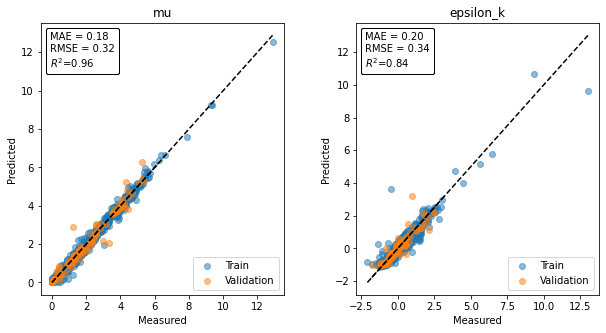

In [18]:
# Setup loggers and callbacks
wandb_logger = pl.loggers.WandbLogger(
    entity="ceb-sre",
    project="dl4thermo",
    tags=["schnetpack"],
    log_model=True,
)
checkpoint_cb = pl.callbacks.ModelCheckpoint(
    dirpath=tmp_dir,
    save_top_k=1, 
    monitor="val_loss",
    mode="min",
    save_weights_only=True,
)
early_stopping_cb = pl.callbacks.EarlyStopping(
    monitor="val_loss", 
    min_delta=0.00, 
    patience=7,
    verbose=False, 
    mode="min"
)
lr_monitor_cb = pl.callbacks.LearningRateMonitor()


# Training
trainer = pl.Trainer(
    callbacks=[checkpoint_cb, early_stopping_cb, lr_monitor_cb],
    logger=wandb_logger,
    default_root_dir=tmp_dir,
    max_epochs=100000, # for testing, we restrict the number of epochs
    gpus=1,
    log_every_n_steps=10,
)
trainer.fit(task, datamodule=pcpsData)


# Evaluation
train_pred, val_pred = trainer.predict(
    task, 
    dataloaders=[
        pcpsData.predict_dataloader(), pcpsData.val_dataloader()
    ],
    ckpt_path="best"
)
fig, axes = plt.subplots(1,2, figsize=(10,5))
fig.subplots_adjust(wspace=0.3)
for label, dl,preds in zip(
    ["Train", "Validation"],
    [pcpsData.predict_dataloader(), pcpsData.val_dataloader()],
    [train_pred, val_pred], 
):
    for ax, prop in zip(axes, ["mu", "epsilon_k"]):
        preds_prop = torch.cat([pred[prop] for pred in preds])
        true_prop = torch.cat([d[prop] for d in dl.dataset])
        parity_plot(
            true_prop.detach().numpy(),
            preds_prop.detach().numpy(),
            ax=ax,
            label=label,
            include_scores=True,
        )
        ax.set_title(prop)
        ax.legend(loc="lower right")
plot_path = tmp_dir / "parity.png"
fig.savefig(plot_path, dpi=300)
wandb_logger.log_image(key="parity_plot", images=[str(plot_path)])
wandb.finish(0)

## Inference

Having trained a model for QM9, we are going to use it to obtain some predictions.
First, we need to load the model. The `Trainer` stores the best model in the model directory which can be loaded using PyTorch:

In [ ]:
import torch
import numpy as np
from ase import Atoms
import sklearn.metrics

best_model = torch.load(os.path.join(tmp_dir, 'best_inference_model'), map_location='cpu')

We can use the test dataloader from the QM( data to obtain a batch of molecules and apply the model:

In [ ]:
def infer(dataloader):
    reals = torch.tensor([])
    preds = torch.tensor([])
    for batch in dataloader:
        real = batch[PCPS.mu]
        pred = best_model(batch)["mu"]
        reals = torch.cat([reals, real])
        preds = torch.cat([preds, pred])
    return reals, preds

In [ ]:
test_reals, test_preds = infer(pcpsData.test_dataloader())
print(f"Test MAE: {torch.mean(torch.abs(test_reals-test_preds))}")
print(f"Test MSE: {torch.mean(torch.pow(test_reals-test_preds,2))}")
print(f"Test R2: {sklearn.metrics.r2_score(y_true=test_reals.detach().numpy(), y_pred=test_preds.detach().numpy())}")
val_reals, val_preds = infer(pcpsData.val_dataloader())
print(f"Val MAE: {torch.mean(torch.abs(val_reals-val_preds))}")
print(f"Val MSE: {torch.mean(torch.pow(val_reals-val_preds,2))}")
print(f"Val R2: {sklearn.metrics.r2_score(y_true=val_reals.detach().numpy(), y_pred=val_preds.detach().numpy())}")
train_reals, train_preds = infer(pcpsData.train_dataloader())
print(f"Train MAE: {torch.mean(torch.abs(train_reals-train_preds))}")
print(f"Train MSE: {torch.mean(torch.pow(train_reals-train_preds,2))}")
print(f"Train R2: {sklearn.metrics.r2_score(y_true=train_reals.detach().numpy(), y_pred=train_preds.detach().numpy())}")

/usr/local/lib/python3.8/dist-packages/torch/utils/data/dataloader.py:554: UserWarning: This DataLoader will create 48 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(


Test MAE: 0.43063035826807233
Test MSE: 1.276914579753902
Test R2: 0.730886630065404


/usr/local/lib/python3.8/dist-packages/torch/utils/data/dataloader.py:554: UserWarning: This DataLoader will create 48 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(


Val MAE: 0.1771988844498992
Val MSE: 0.06766702860465014
Val R2: 0.9633071306129826


/usr/local/lib/python3.8/dist-packages/torch/utils/data/dataloader.py:554: UserWarning: This DataLoader will create 48 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(


Train MAE: 0.15657867660264377
Train MSE: 0.04759605795884471
Train R2: 0.9779421840692689
